<!-- # Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes -->

### Time Series analysis

#### Business Understanding 


#### Objectives 
1. Find the top ZipCodes and Metropolitan areas to invest in. 
2. Develop a Time-Series regression model to predict house prices for the next 6 months. 
3. Investigate change of house prices in the top ten States with the most high priced houses. 


In [81]:
import pandas as pd 
import numpy as np 
import itertools 

# Modelling libraries
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import r2_score, mean_squared_error 
from prophet import Prophet 
from neuralprophet import NeuralProphet 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima import auto_arima 

# Visualization libraries
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.tight_layout 
import seaborn as sns 
# Graph Fonts 
plt.rcParams['font.size'] = 12 

import warnings
warnings.filterwarnings('ignore')


### Data Understanding 
We seek out to understand the Zillow data provided containing average house prices. 
1. Check the data information.
2. Check for missing values.
3. Check for duplicated values. 

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [4]:
df.tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,92600.0,92600.0,92800.0,93100.0,93500.0,94000.0,94500.0,95100.0,95800.0,96500.0,97100.0,97800.0,98500.0,99200.0,100000.0,100800.0,101700.0,102600.0,103400.0,104200.0,104900.0,105600.0,106300.0,106800.0,107300.0,107800.0,108400.0,109000.0,109600.0,110200.0,110800.0,111400.0,112000.0,112600.0,113000.0,113500.0,113900.0,114300.0,114800.0,115400.0,116000.0,116700.0,117400.0,118100.0,118700.0,119500.0,120100.0,120600.0,121100.0,121700.0,122400.0,123300.0,124200.0,125300.0,126300.0,127400.0,128500.0,129600.0,130600.0,131400.0,132100.0,133000.0,133900.0,134900.0,136000.0,137200.0,138500.0,139700.0,140900.0,141900.0,143600.0,146300.0,149100.0,150900.0,151800.0,152000.0,151700.0,151700.0,152500.0,154200.0,156700.0,159800.0,163000.0,166000.0,168700.0,171400.0,174100.0,176800.0,179200.0,180800.0,181800.0,182400.0,182800.0,183200.0,183700.0,184300.0,185400.0,187300.0,190000.0,193400.0,197200.0,200600.0,203100.0,204400.0,205000.0,205300.0,205400.0,205500.0,205300.0,205100.0,204800.0,204800.0,204900.0,205200.0,205700.0,206200.0,206500.0,206500.0,206300.0,206100.0,205900.0,205600.0,205000.0,204100.0,202900.0,201600.0,200200.0,198900.0,197800.0,197100.0,196900.0,197300.0,197900.0,198100.0,197800.0,197200.0,196400.0,195600.0,194600.0,193400.0,192200.0,191300.0,190800.0,190700.0,190500.0,189800.0,188700.0,187500.0,186700.0,186600.0,187100.0,187300.0,187500.0,187700.0,188200.0,189000.0,190100.0,190200.0,188500.0,186200.0,184400.0,184400.0,185900.0,188000.0,188900.0,188900.0,187600.0,183700.0,177100.0,173200.0,173000.0,174700.0,176200.0,176300.0,174700.0,174000.0,174800.0,175800.0,175500.0,174600.0,174700.0,175200.0,175400.0,175200.0,175300.0,174500.0,173100.0,172700.0,1732

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

The data has more than 200 columns and should be changed to a long formart. 
The data also does not have any duplicated values. 

The data is in a wide formart and therefore all the columns cannot be displayed to show the missing values. We can only see the Metro column which has 1043 missing values. Data in wide formart is had to do use because no preproccessing can be done it efficiently. Our objectives are tied to the date column and therefore necessarry to convert the data into a long formart for easy analysis. 

### Data Filtering

# Step 2: Data Preprocessing

This step involves engineering new features that may help in understanding the data more better and do anefficient analysis. 
1. Convert the data from the wide to long formart. 
2. Convert the time column into a datetime column. 
3. Engineer new features for the month and year column from the date column. 

In [ ]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [9]:
df_new = melt_data(df)
df_new.head()

,time,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
0,1996-04-01,1001,58196,5851,Agawam,MA,Springfield,Hampden,113100.0
1,1996-04-01,1002,58197,4200,Amherst,MA,Springfield,Hampshire,161000.0
2,1996-04-01,1005,58200,11214,Barre,MA,Worcester,Worcester,103100.0
3,1996-04-01,1007,58201,6851,Belchertown,MA,Springfield,Hampshire,133400.0
4,1996-04-01,1008,58202,14548,Blandford,MA,Springfield,Hampden,117500.0


In [10]:
def get_datetime(df):
    """ 
    Converts the time column into a datteime formart 
    """
    
    return pd.to_datetime(df, format='%Y-%m')

In [11]:
df_new['time'] = get_datetime(df_new['time'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3508681 entries, 0 to 3508680
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   time        datetime64[ns]
 1   RegionName  int64         
 2   RegionID    int64         
 3   SizeRank    int64         
 4   City        object        
 5   State       object        
 6   Metro       object        
 7   CountyName  object        
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 240.9+ MB


In [12]:
df_new.describe()

,RegionName,RegionID,SizeRank,value
count,3.508681e+06,3.508681e+06,3.508681e+06,3.508681e+06
mean,4.767052e+04,8.102196e+04,7.008445e+03,2.139704e+05
std,2.984346e+04,3.320036e+04,4.216100e+03,2.457750e+05
min,1.001000e+03,5.819600e+04,1.000000e+00,1.140000e+04
25%,2.087400e+04,6.670000e+04,3.354000e+03,1.022000e+05
50%,4.523100e+04,7.758000e+04,6.805000e+03,1.519000e+05
75%,7.542300e+04,9.105800e+04,1.058800e+04,2.448000e+05
max,9.990100e+04,7.538440e+05,1.472300e+04,1.931490e+07


In [13]:
df_new['Year'] = df_new['time'].dt.year
df_new['Month'] = df_new['time'].dt.month

To get the zipcodes with the most expensive houses that may proove good investments, the concept of binning the zipcodes represented by **Region name** comes in handy. The zipcodes are unique for every state contained in the zillow dataset.

To get the correct number of bins to use, the **length** of the **State** column must be found.

In [14]:
len(df_new['State'].value_counts())

51

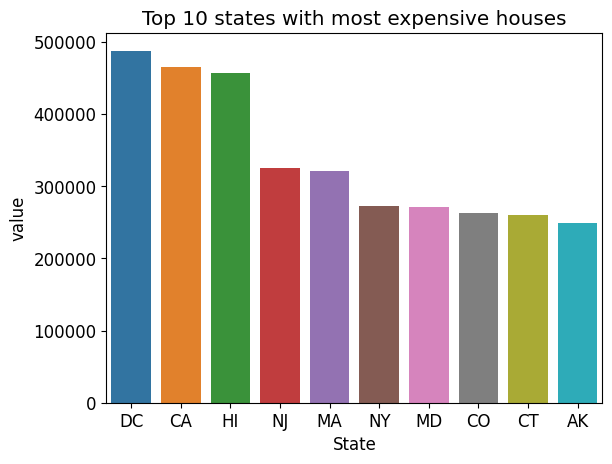

In [15]:
# Most expensive states 
state_exp = pd.DataFrame(df_new.groupby(['State'])['value'].agg('mean').sort_values(ascending=False).head(10))
sns.barplot(data=state_exp.reset_index(), x='State', y='value')
plt.title("Top 10 states with most expensive houses")
plt.show()

The top ten states with expensive houses include **Washington DC, California, Hawaii, New Jersey, Massacheutts, New York, Maryland, Colorado, Connecticut** and **Alaska**. To get the top ten zipcodes to invest in, we will narrow it down to these top expensive States.  

In [16]:
states = df_new[df_new['State'] == 'DC']
states

,time,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,Year,Month
3111,1996-04-01,20001,66125,259,Washington,DC,Washington,District of Columbia,92000.0,1996,4
3112,1996-04-01,20002,66126,30,Washington,DC,Washington,District of Columbia,94300.0,1996,4
3113,1996-04-01,20003,66127,1449,Washington,DC,Washington,District of Columbia,130000.0,1996,4
3114,1996-04-01,20007,66131,2654,Washington,DC,Washington,District of Columbia,358100.0,1996,4
3115,1996-04-01,20008,66132,1264,Washington,DC,Washington,District of Columbia,450100.0,1996,4
...,...,...,...,...,...,...,...,...,...,...,...
3498214,2018-04-01,20019,66142,247,Washington,DC,Washington,District of Columbia,308600.0,2018,4
3498215,2018-04-01,20020,66143,403,Washington,DC,Washington,District of Columbia,337000.0,2018,4
3498216,2018-04-01,20024,66146,5298,Washington,DC,Washington,District of Columbia,885000.0,2018,4
3498217,2018-04-01,20032,66151,1708,Washington,DC,Washington,District of Columbia,307400.0,2018,4


In [17]:
top_ten_states = ['DC','CA','HI','NJ','MA','NY','MD','CO','CT','AK'] 
subset_df = df_new[df_new['State'].isin(top_ten_states)]  
best_zipcodes = pd.DataFrame(subset_df.groupby(['RegionName'])['value'].agg('mean').sort_values(ascending=False).head(10))


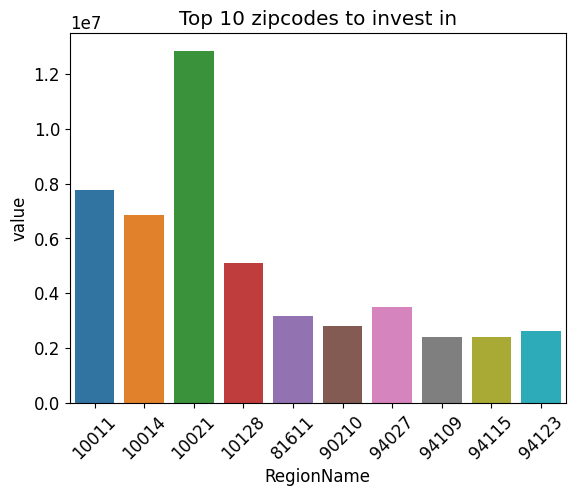

In [18]:

sns.barplot(data=best_zipcodes.reset_index(), x='RegionName', y='value')
plt.title("Top 10 zipcodes to invest in")
plt.xticks(rotation=45)
plt.show()

The top most zipcodes to invest in are:
1. ZipCode **10021, 10011, 10014 and 10128** in **New York City**
2. ZipCode **94027** in **Western California** 
3. ZipCode **81611** in **Western Colorado**
4. ZipCode **90210** in **Beverly Hills**
5. ZipCode **94123, 94109 and 94115** in **San Fransisco** 

This is because the houses have higher values and equally fetch for higher prices signifying presence of High Income earners which guarantees a good **Return On Investment**

In [19]:
subset_df

,time,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,Year,Month
0,1996-04-01,1001,58196,5851,Agawam,MA,Springfield,Hampden,113100.0,1996,4
1,1996-04-01,1002,58197,4200,Amherst,MA,Springfield,Hampshire,161000.0,1996,4
2,1996-04-01,1005,58200,11214,Barre,MA,Worcester,Worcester,103100.0,1996,4
3,1996-04-01,1007,58201,6851,Belchertown,MA,Springfield,Hampshire,133400.0,1996,4
4,1996-04-01,1008,58202,14548,Blandford,MA,Springfield,Hampden,117500.0,1996,4
...,...,...,...,...,...,...,...,...,...,...,...
3508676,2018-04-01,99705,100380,5515,North Pole,AK,Fairbanks,Fairbanks North Star,262000.0,2018,4
3508677,2018-04-01,99709,100384,4527,Fairbanks,AK,Fairbanks,Fairbanks North Star,262400.0,2018,4
3508678,2018-04-01,99712,100387,8439,Fairbanks,AK,Fairbanks,Fairbanks North Star,274600.0,2018,4
3508679,2018-04-01,99801,100459,4107,Juneau,AK,Juneau,Juneau,413300.0,2018,4


In [20]:
# Top metropolitan areas with high house values 
subset_df2 = pd.DataFrame(subset_df.groupby(['CountyName','Metro'])['value'].agg('mean').sort_values(ascending=False).head(20))
subset_df2


,,value
CountyName,Metro,
New York,New York,5.314744e+06
Pitkin,Glenwood Springs,2.092172e+06
San Francisco,San Francisco,1.160127e+06
San Mateo,San Francisco,9.725121e+05
Marin,San Francisco,9.236627e+05
Santa Clara,San Jose,8.315191e+05
Santa Barbara,Santa Maria-Santa Barbara,6.471310e+05
Dukes,Vineyard Haven,6.438442e+05
Orange,Los Angeles-Long Beach-Anaheim,6.245591e+05


The top Metropolitan areas to invest in are:
1. New York 
2. San Fransisco 
3. Glenwood Springs. 

Metropolitant areas always have alot of industrial processes as well as huge populations in the wake of rural-urabrn migration. The need for housing in these urbarn areas is high and therefore the housing markert has very ready markert for Real Estate investors. 

In [21]:
# top_ten_states = ['DC','CA','HI','NJ','MA','NY','MD','CO','CT','AK']
# subset_df = df_new[df_new['State'].isin(top_ten_states)] 
# subset_df.set_index('time', inplace=True) 

# bar_animation = pd.DataFrame(subset_df.groupby(['time','State'])['value'].agg('sum')).reset_index()
# bar_animation['cumulative_sum'] = bar_animation.groupby('State')['value'].cumsum() 
# bar_animation 
 

In [22]:
# import bar_chart_race as br 

# bar = br.bar_chart_race(df=bar_animation, filename=None, figsize=(3.5,3), title="House price changes by state")

# Step 3: EDA and Visualization

# Step 4: Modelling

In [67]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [77]:
df_model = melt_data(df)
df_model.describe()

,value
count,265.000000
mean,206661.505593
std,47809.380643
min,118299.123063
25%,168653.357200
50%,215113.127917
75%,245934.664560
max,288039.944305


<AxesSubplot: xlabel='time'>

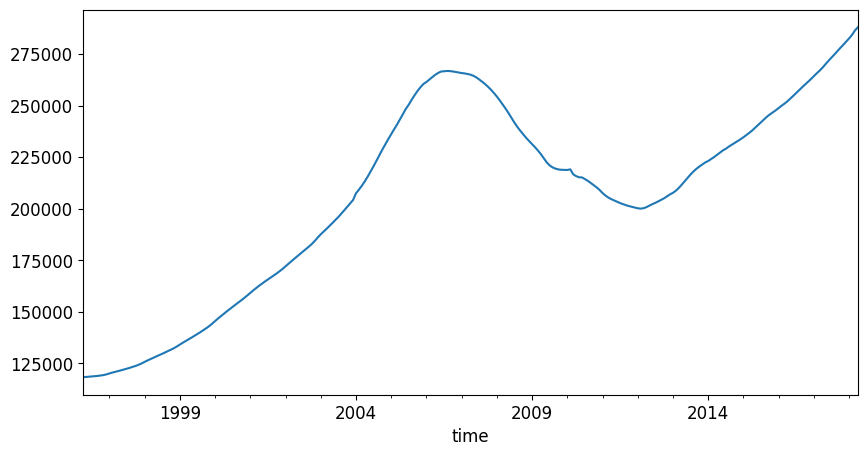

In [80]:
df_model['value'].plot(figsize=(10,5))

Going by the plot, the data exhibits some concept of seasonality.

The average House prices seem to have dropped between the year **2007 to 2012** before finally picking up after 2012. This was because of the 2008 House crisis in the US where housing markert stalled and interest rates were high. It is well outlined in the article [https://www.americanprogress.org/article/2008-housing-crisis/] 

#### Stationary Check

In [82]:
def corr_plots(data):
    acf_diff = plot_acf(data)
    pacf_plot = plot_pacf(data)
    
    return acf_diff, pacf_plot 

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

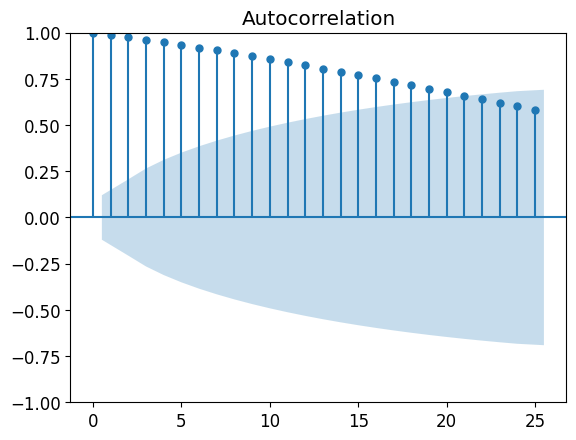

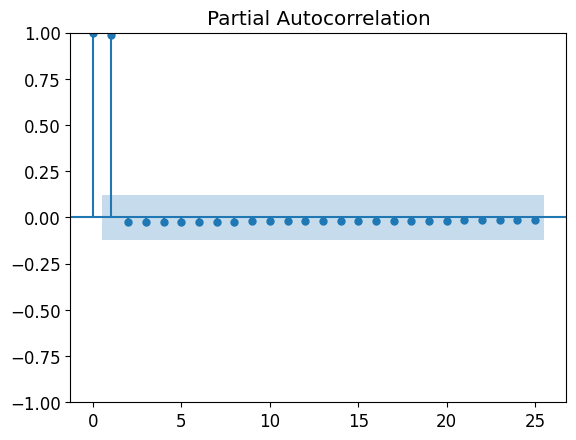

In [83]:
corr_plots(df_model)

In [74]:
#Testing for data stationarity. 
def adfuller_test(data):
    print("Results of Dickey Fuller test:")
    adftest = adfuller(data)
    print(f'Test Statistic: {adftest[0]}')
    print(f'P-value: {adftest[1]}')


In [76]:
adfuller_test(df_model['value'])

Results of Dickey Fuller test:
Test Statistic: -1.8851445183777964
P-value: 0.3390815439412521


Testing for stationarity using the adfuller test generates a p-value greater than 0.05 which leads to the conclusion of rejecting the NULL hypothesis that the data is Stationary. 


#### Removing stationarity

<AxesSubplot: xlabel='time'>

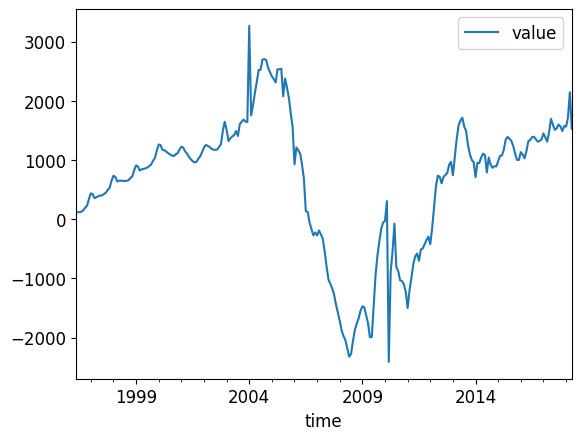

In [84]:
df_model_diff = df_model.diff().dropna()
df_model_diff.plot()

In [85]:
adfuller_test(df_model_diff)

Results of Dickey Fuller test:
Test Statistic: -2.5487815968340075
P-value: 0.10405172262326728


The data is not yet stationary because the P-value is still greater than 0.05

Results of Dickey Fuller test:
Test Statistic: -2.308423606544986
P-value: 0.16926558209810333


<AxesSubplot: xlabel='time'>

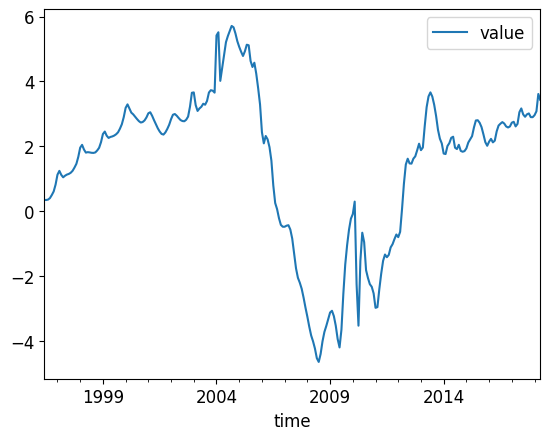

In [96]:
df_model_diff2 = np.sqrt(df_model)
df_model_diff3 = df_model_diff2.diff(2).dropna()
adfuller_test(df_model_diff3)
df_model_diff3.plot()


In [94]:
# Split the data into train and test sets 
print(len(df_model))
train = df_model.iloc[:-45]
test = df_model.iloc[-45:] 
print(train, test)

265
                    value
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312
...                   ...
2014-03-01  225082.573123
2014-04-01  226124.783528
2014-05-01  227232.010636
2014-06-01  228310.622486
2014-07-01  229099.280038

[220 rows x 1 columns]                     value
time                     
2014-08-01  230141.744210
2014-09-01  231060.035319
2014-10-01  231927.514773
2014-11-01  232822.135434
2014-12-01  233712.307274
2015-01-01  234691.190654
2015-02-01  235760.279834
2015-03-01  236836.426000
2015-04-01  238009.760239
2015-05-01  239354.207702
2015-06-01  240744.121443
2015-07-01  242103.525097
2015-08-01  243424.444746
2015-09-01  244658.269374
2015-10-01  245764.565646
2015-11-01  246765.041092
2015-12-01  247765.170142
2016-01-01  248896.366230
2016-02-01  249987.312368
2016-03-01  251014.310942
2016-04-01  252164.273586
2016-05-01  253483.637846
2016-06-01

In [57]:

p = range(0,8)
q = range(0,8)
d = range(0,2)

pdq_combinations = list(itertools.product(p,d,q))

aic_scores = []
rmse = []
order_1 = []

for pdq in pdq_combinations:
    try:
        model = ARIMA(train, order=pdq).fit()
        pred = model.predict(start=len(train), end=len(train)+ len(test)-1, typ='levels')
        error = np.sqrt(mean_squared_error(pred, test['value']))
        aic = model.aic 
        aic.append(aic_scores)
        order_1.append(pdq)
        rmse.append(error) 
    except:
        continue 
    
results = pd.DataFrame(index=order_1, data=rmse, data={'RMSE': rmse, 'AIC': aic_scores})
results.to_csv("combinations.csv")

The optimum pdq values are saved in a csv file. These pdq values help to attain to make a data stationary during the training process. 

In [66]:
baseline_model2 = ARIMA(differencing, order=(0,1,0)).fit()

print(baseline_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  264
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2678.631
Date:                Tue, 16 Jan 2024   AIC                           5359.263
Time:                        10:09:05   BIC                           5362.835
Sample:                    05-01-1996   HQIC                          5360.698
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.096e+07   3.16e+06     12.958      0.000    3.48e+07    4.72e+07
Ljung-Box (L1) (Q):                  92.27   Jarque-Bera (JB):                 3.13
Prob(Q):                              0.00   Pr

# Step 5: ARIMA Modeling

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby(['time','RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName']).aggregate({'value':'mean'}).reset_index()

# Step 6: Interpreting Results